**Experiment:** A/B Test for New Landing Page Design

**Hypothesis:**
H0: The existing design and the new design ***have*** the same conversion rate.
H1: The existing design and the new design ***do not*** have the same conversion rate.

**Participants:** Users visiting the landing page.

**Variables to Test:** Old Page and New Page

**Metric:** Conversion Rate

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Loading Packages
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as sp

**Importing and Exploring the Dataset**

In [27]:
path = "/content/drive/MyDrive/ab_data.csv"
df = pd.read_csv(path)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 294478 rows and 5 columns


In [17]:
df.describe()

,user_id,timestamp,converted
count,294478.000000,294478,294478.000000
mean,787974.124733,2017-01-13 13:40:10.474213376,0.119659
min,630000.000000,2017-01-02 13:42:05.378582,0.000000
25%,709032.250000,2017-01-08 02:06:48.649925120,0.000000
50%,787933.500000,2017-01-13 13:21:07.016475904,0.000000
75%,866911.750000,2017-01-19 01:43:51.611873792,0.000000
max,945999.000000,2017-01-24 13:41:54.460509,1.000000
std,91210.823776,NaN,0.324563


In [13]:
#Looking for Duplicated Values
df.duplicated().sum()

0

In [12]:
#Looking for Null Values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [28]:
#Changing the Current Timestamp to a datatime Datatype
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['datetime'] = df['timestamp'].dt.date

In [16]:
first_session = df['timestamp'].min()
last_session = df['timestamp'].max()
duration = df['timestamp'].dt.day.max() - df['timestamp'].dt.day.min()

print(f'First Session Datetime: {first_session}')
print(f'Last Session Datetime: {last_session}')
print(f'This experimental design ran for {duration} days')

First Session Datetime: 2017-01-02 13:42:05.378582
Last Session Datetime: 2017-01-24 13:41:54.460509
This experimental design ran for 22 days


In [23]:
old_page_shape = df[df['landing_page'] == 'old_page'].shape
new_page_shape = df[df['landing_page'] == 'new_page'].shape

print(f'Old Page Shape: {old_page_shape}')
print(f'New Page Shape: {new_page_shape}')

Old Page Shape: (147239, 6)
New Page Shape: (147239, 6)


In [24]:
control_group_shape = df[df['group'] == 'control'].shape
treatment_group_shape = df[df['group'] == 'treatment'].shape

print(f'Control Group Shape: {control_group_shape}')
print(f'Treatment Group Shape: {treatment_group_shape}')

Control Group Shape: (147202, 6)
Treatment Group Shape: (147276, 6)


In [18]:
#Number of Individuals in Treatment and Control Groups
df['group'].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

In [19]:
df['converted'].value_counts()

converted
0    259241
1     35237
Name: count, dtype: int64

In [20]:
df['landing_page'].value_counts()

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

In [22]:
df.groupby(['datetime','group']).agg(user_id=('user_id','count')).reset_index()

,datetime,group,user_id
0,2017-01-02,control,2894
1,2017-01-02,treatment,2889
2,2017-01-03,control,6684
3,2017-01-03,treatment,6710
4,2017-01-04,control,6655
5,2017-01-04,treatment,6629
6,2017-01-05,control,6538
7,2017-01-05,treatment,6586
8,2017-01-06,control,6684
9,2017-01-06,treatment,6844


In [25]:
df.groupby(['group', 'landing_page']).agg(
    num_user=('user_id', 'count'),
    convert=('converted', 'sum')
).reset_index()

,group,landing_page,num_user,convert
0,control,new_page,1928,234
1,control,old_page,145274,17489
2,treatment,new_page,145311,17264
3,treatment,old_page,1965,250


In [26]:
#find the daily active users

daily_active_users = df.groupby('datetime')['user_id'].nunique().reset_index()
daily_active_users.rename(columns={'user_id': 'daily_active_users'}, inplace=True)
daily_active_users


,datetime,daily_active_users
0,2017-01-02,5783
1,2017-01-03,13387
2,2017-01-04,13274
3,2017-01-05,13116
4,2017-01-06,13519
5,2017-01-07,13373
6,2017-01-08,13556
7,2017-01-09,13432
8,2017-01-10,13518
9,2017-01-11,13547


**Number of Conversions**

In [30]:
# Group by 'group' and 'dt', then sum the 'converted' column
data_group2 = (
    df.groupby(['group', 'datetime'])
    .agg(num_convert=('converted', 'sum'))
    .reset_index()
)

# Convert the 'dt' column to datetime format
data_group2['datetime'] = pd.to_datetime(data_group2['datetime'])

# Output the resulting DataFrame
data_group2

,group,datetime,num_convert
0,control,2017-01-02,362
1,control,2017-01-03,760
2,control,2017-01-04,810
3,control,2017-01-05,801
4,control,2017-01-06,778
5,control,2017-01-07,805
6,control,2017-01-08,805
7,control,2017-01-09,806
8,control,2017-01-10,763
9,control,2017-01-11,808


<ipython-input-33-8f967ba602c3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data_group2, x='num_convert', y='group', inner='stick', palette='Dark2')


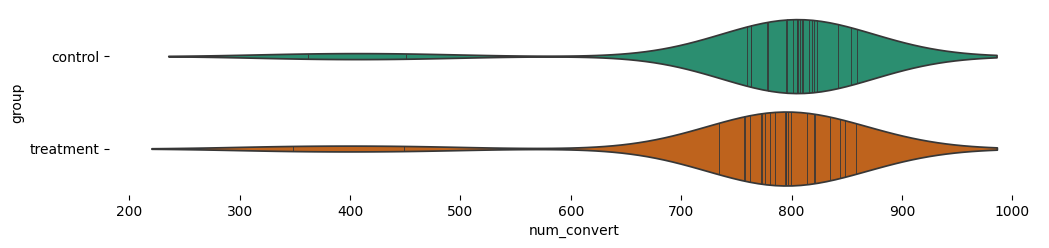

In [33]:
# group vs num_convert
figsize = (12, 1.2 * len(data_group2['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data_group2, x='num_convert', y='group', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

**Creating Control and Treatment Groups**

In [34]:
control = df[df['group']=='control']
treatment = df[df['group']=='treatment']

**Calculating the Conversion Success Rates for the Control and Treatment Groups**

In [35]:
# Calculate the number of conversions and total observations for the control group
total_conversions_control = control['converted'].sum()
total_observations_control = control['converted'].count()

# Calculate the number of conversions and total observations for the treatment group
total_conversions_treatment = treatment['converted'].sum()
total_observations_treatment = treatment['converted'].count()

# Print the results using formatted strings (f-strings)
print(f'Total Conversions (Control): {total_conversions_control}')
print(f'Total Conversions (Treatment): {total_conversions_treatment}')
print(f'Total Observations (Control): {total_observations_control}')
print(f'Total Observations (Treatment): {total_observations_treatment}')

Total Conversions (Control): 17723
Total Conversions (Treatment): 17514
Total Observations (Control): 147202
Total Observations (Treatment): 147276


In [37]:
# Calculate conversion rates
control_conversion_rate = (total_conversions_control / total_observations_control) * 100
treatment_conversion_rate = (total_conversions_treatment / total_observations_treatment) * 100

# Print conversion rates
print(f'Conversion Rate from Control: {control_conversion_rate:.3f}%')
print(f'Conversion Rate from Treatment: {treatment_conversion_rate:.3f}%')

Conversion Rate from Control: 12.040%
Conversion Rate from Treatment: 11.892%


**Z-Test**

I am using a z-test to determine if there is a statistically significant difference in conversion rates between the old page and the new page. This method relies on the assumption that the sampling distribution of proportions is approximately normal and that sample sizes are sufficiently large. This approach allows me to make informed decisions about which page design—old or new—is more effective in converting customers.

In [38]:
# Define arrays
success = np.array([total_conversions_control, total_conversions_treatment])
obs = np.array([total_observations_control, total_observations_treatment])

# Perform proportions z-test
statistic, pvalue = sp.proportions_ztest(success, obs)

# Print results
print(f'P-Value: {pvalue:.4f}')

# Compare p-value with significance level (e.g., 0.05)
if pvalue >= 0.05:
    print('Insufficient evidence to reject H0')
else:
    print('Sufficient evidence to reject H0')

P-Value: 0.2161
Insufficient evidence to reject H0


The difference in the number of converted customers between the new and old pages is negligible. Consequently, the new page design did not succeed in increasing conversions significantly. Either the existing page or the new page can be implemented, as they showed similar effectiveness in converting customers.